In [ ]:
import torch
import numpy as np
from torch import nn 
import random
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
imiona = open("imionapl.txt", encoding = "UTF-8").read().splitlines()
imiona = [i.lower() for i in imiona]
imiona[:5]

['ada', 'adalbert', 'adam', 'adela', 'adelajda']

In [ ]:
chars = sorted(list(set(''.join(imiona))))
stoi = {s:i +1  for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i :s for s, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

31


In [ ]:
block_size = 3 
def build_dataset(imiona):  
    X, Y = [], []
    for w in imiona:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
random.seed(42)
random.shuffle(imiona)
n1 = int(0.8*len(imiona))
n2 = int(0.9*len(imiona))

X_train, Y_train = build_dataset(imiona[:n1])
X_dev, Y_dev = build_dataset(imiona[n1:n2])
X_test, Y_test = build_dataset(imiona[n2:])
    

torch.Size([3919, 3]) torch.Size([3919])
torch.Size([510, 3]) torch.Size([510])
torch.Size([480, 3]) torch.Size([480])


### mini-batch mean
#### (1) $  \mu_{\beta} ← \frac{1}{m}\sum_{i=1}^{m} x_{i} $ 
### mini-batch variance
#### (2)$  \sigma^2_{\beta} ← \frac{1}{m}\sum_{i=1}^{m} (x_{i} - \mu_{\beta})^2 $
### normalize
#### (3)$ \hat{x_{i}} ← \frac{x_{i} -\mu_{\beta} }{\sqrt{\sigma^2_{\beta} + \epsilon}}$
### scale and shift
#### (4) $y_{i} ← \gamma \hat{x_{i}} + β $

In [ ]:
dims = 10 
hidden_neurons = 200

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, dims))
W1_3 = torch.randn((dims*block_size, hidden_neurons), generator = g) * (5/3)/((dims*block_size)**0.5) #5/3 is a fixed value for tanh activation known as "gain"
b1_3 = torch.randn((hidden_neurons), generator = g) * 0 
W2_3 = torch.randn((hidden_neurons, vocab_size), generator = g)* (5/3)/((hidden_neurons)**0.5)
b2_3 = torch.randn((vocab_size), generator = g) * 0 

# gain and bias initialization (4)
batch_gain = torch.ones((1, hidden_neurons))
batch_bias = torch.zeros((1, hidden_neurons))

#buffers of bn layer(not trained during backprop) 
batch_mean_running = torch.ones((1, hidden_neurons))
batch_std_running = torch.zeros((1, hidden_neurons))


parameters_3 = [C, W1_3, W2_3, b1_3,b2_3, batch_gain, batch_bias]
def enable_grad(parameters):
    for p in parameters:
        p.requires_grad = True
enable_grad(parameters_3)

In [ ]:
batch_bias

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)

In [ ]:
def model(X_train,Y_train, batch_size, parameters, max_steps, batch_mean_running, batch_std_running):
    losses, accuracies = [],[]
    C, W1, W2, b1,b2, batch_gain, batch_bias = parameters
    for i in range(max_steps):

        ix = torch.randint(0, X_train.shape[0], (32,))
        X_batched, Y_batched = X_train[ix], Y_train[ix]
        # forward pass
        emb = C[X_batched]
        #print(f"""emb :{emb.shape}""")
        embcat = emb.view(emb.shape[0], -1)
        # Linear layer
        h_preact = embcat @ W1 + b1
        #calculate mean and std of activations that are feeding into vb layer over that batch
        batch_mean_i = h_preact.mean(0, keepdims = True) #(1)
        batch_std_i =  h_preact.std(0, keepdims = True) #(2)
        # 'centering' batch to be unit gaussian 
        centered = ( h_preact - batch_mean_i)/ batch_std_i
        #offsetting and scaling by learned bias and gain 
        h_preact = batch_gain * centered + batch_bias  #(3)(4)
        #done on the side of gradient based optimization
        with torch.no_grad():
            batch_mean_running = batch_mean_running * 0.999 + 0.001 * batch_mean_i
            batch_std_running = batch_std_running * 0.999 + 0.001 * batch_std_i
        h = torch.tanh(h_preact)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y_batched)
        cat = torch.argmax(logits, dim=1)
        accuracy = (cat == Y_batched).float().mean()
        if i % 100 == 0:
            print(f"""loss :{loss.item()}, accuracy :{accuracy.item()}""")
        losses.append(loss.item())
        accuracies.append(accuracy.item())
        #backward
        for p in parameters:
            p.grad = None
        loss.backward()


        for p in parameters:
            p.data += -0.15 * p.grad

    plt.plot(np.arange(max_steps), losses);
    plt.plot(np.arange(max_steps), accuracies);

loss :3.6712703704833984, accuracy :0.03125
loss :2.7460412979125977, accuracy :0.1875
loss :1.7658580541610718, accuracy :0.53125
loss :2.4088664054870605, accuracy :0.25
loss :2.4749369621276855, accuracy :0.25
loss :2.0672836303710938, accuracy :0.4375
loss :2.253607988357544, accuracy :0.34375
loss :2.4716100692749023, accuracy :0.3125
loss :2.2545838356018066, accuracy :0.34375
loss :2.319652795791626, accuracy :0.34375


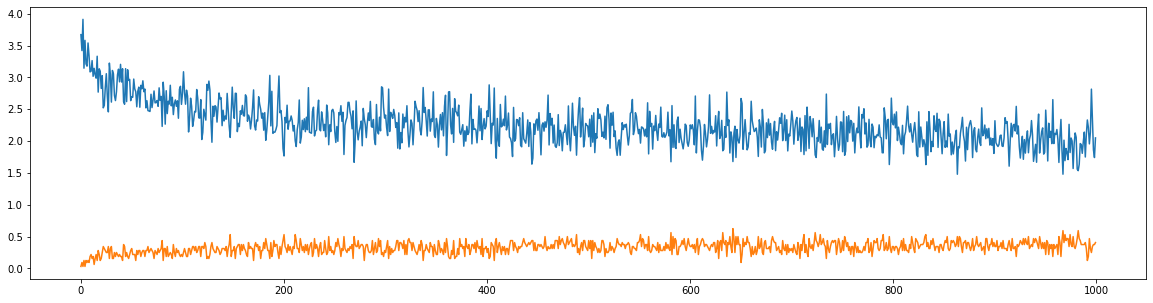

In [ ]:
plt.figure(figsize = (20,5))
model(X_train,Y_train, 32, parameters_3, 1000, batch_mean_running, batch_std_running)

In [ ]:

with torch.no_grad():
    def split_loss(split_x, split_y, parameters):
        C, W1, W2, b1,b2, batch_gain, batch_bias = parameters
        emb = C[split_x] # (N, block_size, n_embd)
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        h_preact = embcat @ W1  + b1
        h_preact = batch_gain * ( h_preact - h_preact.mean(0, keepdims = True)) / h_preact.std(0, keepdims = True) + batch_bias
        h = torch.tanh(h_preact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        loss = F.cross_entropy(logits, split_y)
        print(f"""loss :{loss.item()}""")

print("losses for parameters")
split_loss(X_train, Y_train, parameters_3)
split_loss(X_test, Y_test, parameters_3)

losses for parameters
loss :1.9971873760223389
loss :2.268864870071411


In [ ]:

with torch.no_grad():
    emb = C[X_train]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1_3 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [ ]:
bnmean

tensor([[ 3.1984e-01,  5.2217e-01, -7.9829e-02, -1.0135e-01,  1.8323e-01,
         -7.5055e-02,  4.9862e-02, -1.6886e-01, -7.6759e-01,  1.2014e+00,
         -7.5713e-01, -4.1481e-01,  1.9544e-01,  4.3717e-03,  5.4811e-02,
         -2.2843e-01,  3.9826e-01, -5.3110e-02,  1.8712e-01,  5.9618e-02,
         -3.1927e-01,  5.3590e-01,  5.1462e-01,  4.8048e-01, -1.3488e-01,
          6.2449e-01, -1.5619e-01,  4.2602e-02,  1.2785e-01, -3.6635e-02,
         -1.9286e-01,  3.2577e-01, -9.4643e-01, -5.3046e-04,  4.7085e-01,
          2.0819e-01, -1.2991e-01,  6.6369e-02,  6.6322e-03, -3.0688e-01,
         -7.4402e-01,  4.9400e-01,  5.8447e-01, -7.7134e-02, -2.4537e-01,
          7.1000e-02, -5.3383e-01,  6.6503e-01,  2.4740e-03, -2.0807e-01,
          4.5305e-01, -3.1045e-01, -3.9540e-01,  3.8484e-01, -9.9256e-02,
         -1.0550e+00, -1.1901e+00,  2.0518e-01,  8.2457e-02, -4.0181e-01,
         -3.4613e-01,  6.0741e-01, -4.0601e-01,  1.0704e-01,  3.3740e-01,
          7.5800e-01, -9.2854e-02, -3.